# Problem 5+
## Plot and approximate the phase portrait of coupled pendula.

In [2]:

import os
import argparse
import time
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.integrate import odeint as odeint_scipy

!pip install torchdiffeq
argadjoint = True

if argadjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint






## Parameters

In [11]:
argbatch_time = 10
argbatch_size = 10
argniters = 1000
argtest_freq = 20
argviz = True
arggpu = 0
device = torch.device('cuda:' + str(arggpu) if torch.cuda.is_available() else 'cpu')


## ODE function + Visualization

In [12]:
class pendula_func_tensor(nn.Module):

    def forward(self,t,y):
        # print (y)
        phi1, phi2, phi1dot, phi2dot = y 
        
        phi1ddot = -(k * (l ** 2)/m/(L ** 2)+g/L)*phi1 + k*(l ** 2)/m/(L ** 2) * phi2
        phi2ddot = -(k* (l ** 2)/m/(L ** 2)+g/L)*phi2+ (l ** 2)/m/(L ** 2) * (k*phi1)
        return torch.tensor(([phi1dot, phi2dot,phi1ddot, phi2ddot])).to(device)



def pendula_func(y, t, k, l, m1, m2, L, g):
    phi1, phi2, phi1dot, phi2dot = y
    phi1ddot = -(k * (l ** 2)/m/(L ** 2)+g/L)*phi1 + k*(l ** 2)/m/(L ** 2) * phi2
    phi2ddot = -(k* (l ** 2)/m/(L ** 2)+g/L)*phi2+ (l ** 2)/m/(L ** 2) * (k*phi1)
    return [phi1dot, phi2dot,phi1ddot, phi2ddot]



font_size = 30
font_size_leg = 20

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(argdata_size - argbatch_time, dtype=np.int64), argbatch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:argbatch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(argbatch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

def visualize(true_y, pred_y, odefunc, itr):

    if argviz:
        fig, (ax_traj, ax_phase,ax_phase1) = plt.subplots(1, 3,figsize=(20,10))
        ax_traj.set_title('Angular displacement', fontsize = font_size)
        ax_traj.set_xlabel('t', fontsize = font_size)
        ax_traj.set_ylabel('$\phi$', fontsize = font_size)
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0], label = '1st pendula true displacement')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 1], label = '2nd pendula true displacement')

      
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0], 'g--', label = '1st pendula pred displacement')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 1], 'b--', label = '2nd pendula pred displacement')


        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        ax_traj.set_ylim(np.min(true_y.cpu().numpy()), np.max(true_y.cpu().numpy()))
        ax_traj.legend(fontsize = font_size_leg)

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait 1', fontsize = font_size)
        ax_phase.set_xlabel('$\phi$', fontsize = font_size)
        ax_phase.set_ylabel('$d\phi / dt$', fontsize = font_size)


        ax_phase1.cla()
        ax_phase1.set_title('Phase Portrait 2', fontsize = font_size)
        ax_phase1.set_xlabel('$\phi$', fontsize = font_size)
        ax_phase1.set_ylabel('$d\phi / dt$', fontsize = font_size)



        ax_phase.plot(true_y.cpu().numpy()[:, 0], true_y.cpu().numpy()[:, 2], label = 'true')
        ax_phase1.plot(true_y.cpu().numpy()[:, 1], true_y.cpu().numpy()[:, 3],  label = 'true')
        ax_phase.plot(pred_y.cpu().numpy()[:, 0], pred_y.cpu().numpy()[:, 2],'g--',label = 'pred')
        ax_phase1.plot(pred_y.cpu().numpy()[:, 1], pred_y.cpu().numpy()[:, 3], 'b--', label = 'pred')
        ax_phase1.set_xlim(np.min(true_y.cpu().numpy()), np.max(true_y.cpu().numpy()))
        ax_phase1.set_ylim(np.min(true_y.cpu().numpy()), np.max(true_y.cpu().numpy()))
        ax_phase1.legend(fontsize = font_size_leg)

        ax_phase.set_xlim(np.min(true_y.cpu().numpy()), np.max(true_y.cpu().numpy()))
        ax_phase.set_ylim(np.min(true_y.cpu().numpy()), np.max(true_y.cpu().numpy()))
        ax_phase.legend( fontsize = font_size_leg)


        plt.draw()
        plt.pause(0.001)


class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(4, 50),
            nn.Tanh(),
            # nn.Linear(50, 50),
            # nn.Tanh(),
            nn.Linear(50, 4),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):

        return self.net(y)


class RunningAverageMeter(object):

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


## Solution

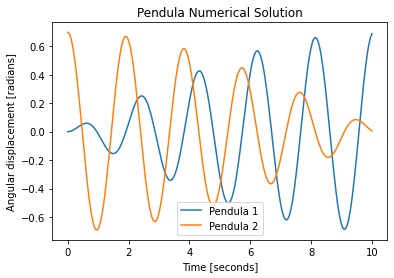

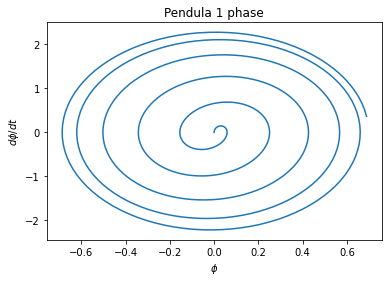

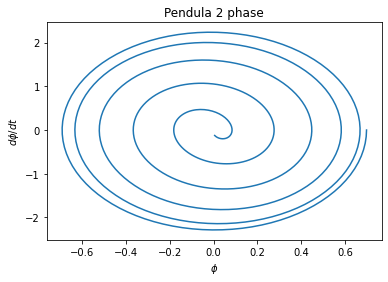

In [17]:
l = 1.0
k = 1.0
m = 1.0
L = 1.0
g = 9.8

y0 = [math.radians(0), math.radians(40), 0, -0.0]  #[math.radians(0), math.radians(40), 3, -0.0]
true_y0 =  torch.tensor(y0).to(device) 

initialTime = 0.0
finalTime = 10.0
stepSize = 0.02
t = torch.tensor(np.linspace(initialTime, finalTime, num=int(finalTime/stepSize))).to(device)

argdata_size = len(t)

solution = odeint_scipy(pendula_func,y0 , t.cpu(), args=(k, l, m, m, L, g))
# solution = odeint(pendula, [math.radians(3.0), math.radians(-3.0), 5.0, 2.0], t, args=(k, l, m, m, L, g))
plt.figure()
plt.xlabel("Time [seconds]")
plt.ylabel("Angular displacement [radians]")
plt.plot(t.cpu(), solution[:,0])
plt.plot(t.cpu(), solution[:,1])
plt.title('Pendula Numerical Solution')
plt.legend(('Pendula 1', 'Pendula 2'))
plt.show()
plt.figure()

plt.plot(solution[:,0],solution[:,2])
plt.title('Pendula 1 phase')
plt.xlabel('$\phi$')
plt.ylabel('$d\phi / dt$')
plt.show()
plt.figure()

plt.plot(solution[:,1],solution[:,3])
plt.title('Pendula 2 phase')
plt.xlabel('$\phi$')
plt.ylabel('$d\phi / dt$')
plt.show()

In [34]:
methods = ['euler', 'adaptive_heun', 'dopri5' ]


## Model 

In [25]:
total_losses = []
for method in methods:
  with torch.no_grad():
      true_y = odeint(pendula_func_tensor(), true_y0,t, method=method).to(device)

  losses = []
  if True:

      ii = 0

      func = ODEFunc().to(device)
      
      optimizer = optim.Adam(func.parameters(), lr=1e-3)
      end = time.time()

      time_meter = RunningAverageMeter(0.97)
      
      loss_meter = RunningAverageMeter(0.97)

      for itr in range(1, argniters + 1):
          optimizer.zero_grad()
          batch_y0, batch_t, batch_y = get_batch()
          pred_y = odeint(func, batch_y0, batch_t).to(device)
          loss = torch.mean(torch.abs(pred_y - batch_y))
          loss.backward()
          optimizer.step()

          time_meter.update(time.time() - end)
          loss_meter.update(loss.item())

          if itr % argtest_freq == 0:
              with torch.no_grad():
                  pred_y = odeint(func, true_y0, t)
                  loss = torch.mean(torch.abs(pred_y - true_y))
                  losses.append(loss.item())
                  print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                  # visualize(true_y, pred_y, func, ii)
                  ii += 1

          end = time.time()
  total_losses.append(losses)

Iter 0020 | Total Loss 1.375270
Iter 0040 | Total Loss 1.348005
Iter 0060 | Total Loss 1.291307
Iter 0080 | Total Loss 1.247085
Iter 0100 | Total Loss 1.190790
Iter 0120 | Total Loss 1.154270
Iter 0140 | Total Loss 1.150570
Iter 0160 | Total Loss 1.156758
Iter 0180 | Total Loss 1.156087
Iter 0200 | Total Loss 1.152092
Iter 0220 | Total Loss 1.150598
Iter 0240 | Total Loss 1.142158
Iter 0260 | Total Loss 1.125095
Iter 0280 | Total Loss 1.104390
Iter 0300 | Total Loss 1.092570
Iter 0320 | Total Loss 1.074317
Iter 0340 | Total Loss 1.070899
Iter 0360 | Total Loss 1.073422
Iter 0380 | Total Loss 1.084726
Iter 0400 | Total Loss 1.107989
Iter 0420 | Total Loss 1.099475
Iter 0440 | Total Loss 1.124606
Iter 0460 | Total Loss 1.158651
Iter 0480 | Total Loss 1.219673
Iter 0500 | Total Loss 1.286636
Iter 0520 | Total Loss 1.326413
Iter 0540 | Total Loss 1.398697
Iter 0560 | Total Loss 1.393401
Iter 0580 | Total Loss 1.422476
Iter 0600 | Total Loss 1.500233
Iter 0620 | Total Loss 1.261965
Iter 064

## Losses

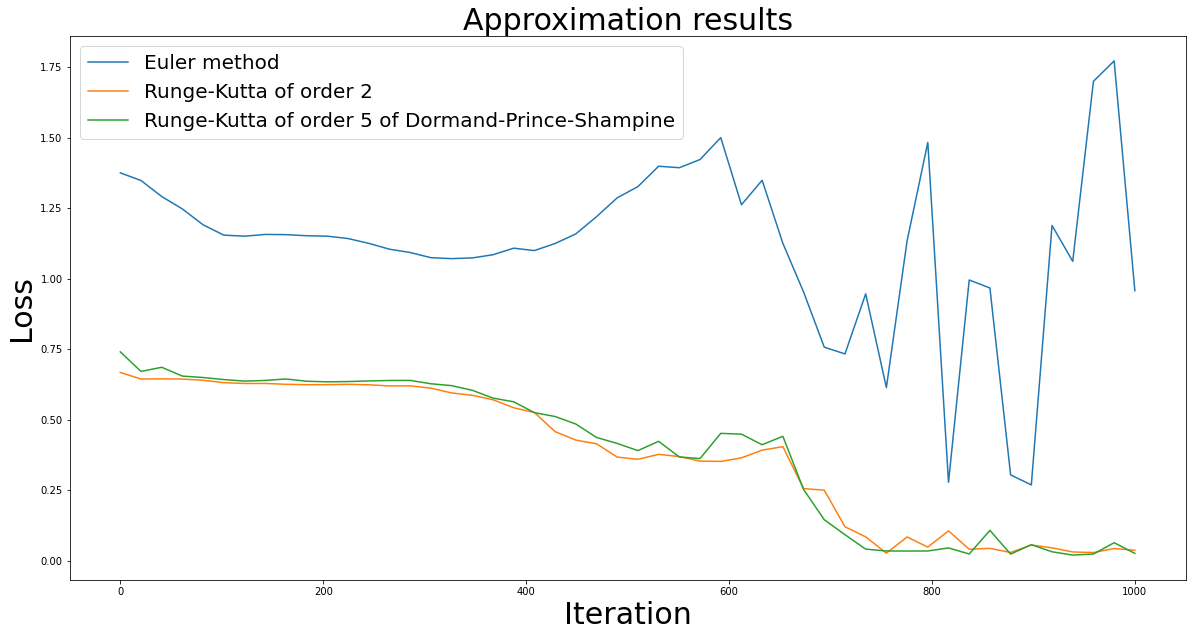

In [32]:
labels = ['Euler method', 'Runge-Kutta of order 2', 'Runge-Kutta of order 5 of Dormand-Prince-Shampine']
plt.figure(figsize = (20,10))
for i in range(3):
  plt.plot(np.linspace(0,1000,50),total_losses[i], label = labels[i])
  # plt.plot(np.linspace(0,1000,50),losses2, label = 'Euler method')
  plt.title('Approximation results',fontsize = 30)
  plt.xlabel('Iteration',fontsize = 30)
  plt.ylabel('Loss',fontsize = 30)
  plt.legend(fontsize = 20)
plt.show()